In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pickle
from tqdm import tqdm
from keras.backend import tensorflow_backend as K

from ssd_data import InputGenerator
from ssd_training import plot_log
from ssd_metric import fscore
from sl_model import SL512, DSODSL512
from sl_metric import evaluate_results

from utils.model_utils import load_weights, calc_memory_usage

np.set_printoptions(linewidth=140, precision=5)

Using TensorFlow backend.


### Data

In [3]:
from data_synthtext import GTUtility
file_name = 'gt_util_synthtext_seglink.pkl'
#gt_util = GTUtility('data/SynthText')
#pickle.dump(gt_util, open(file_name,'wb'))
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)
gt_util_train, gt_util_val = gt_util.split(0.9)

### Model

In [4]:
# SegLink
model = SL512()
#weights_path = './checkpoints/201809231008_sl512_synthtext/weights.001.h5'
weights_path = './checkpoints/201809231008_sl512_synthtext/weights.002.h5'
#weights_path = './checkpoints/201809231008_sl512_synthtext/weights.003.h5'
segment_threshold = 0.6; link_threshold = 0.25
plot_name = 'sl512_sythtext'

In [ ]:
# SegLink + Focal Loss
model = SL512()
weights_path = './checkpoints/201711111814_sl512_synthtext_focal/weights.000.h5'
#weights_path = './checkpoints/201711111814_sl512_synthtext_focal/weights.001.h5'
segment_threshold = 0.57; link_threshold = 0.38 # ???
plot_name = 'sl512_sythtext'

In [ ]:
# SegLink + DenseNet
model = DSODSL512()
#weights_path = './checkpoints/201805161634_dsodsl512_synthtext/weights.001.h5'
weights_path = './checkpoints/201805161634_dsodsl512_synthtext/weights.002.h5'
segment_threshold = 0.57; link_threshold = 0.22 # ???
plot_name = 'dsodsl512_sythtext_ohnm'

In [3]:
# SegLink + DenseNet + Focal Loss
model = DSODSL512()
#weights_path = './checkpoints/201711132011_dsodsl512_synthtext/weights.000.h5'
weights_path = './checkpoints/201711132011_dsodsl512_synthtext/weights.001.h5'
#weights_path = './checkpoints/201711132011_dsodsl512_synthtext/weights.001.128812.h5'
segment_threshold = 0.55; link_threshold = 0.45
plot_name = 'dsodsl512_sythtext'

In [ ]:
# SegLink + DenseNet + Focal Loss b
model = DSODSL512()
weights_path = './checkpoints/201806021007_dsodsl512_synthtext/weights.012.h5'
#weights_path = './checkpoints/201806021007_dsodsl512_synthtext/weights.017.h5'
segment_threshold = 0.55; link_threshold = 0.45
plot_name = 'dsodsl512_sythtext_b'

In [5]:
load_weights(model, weights_path)
checkdir = os.path.dirname(weights_path)

from sl_utils import PriorUtil
prior_util = PriorUtil(model)

### Prediction

In [ ]:
_, inputs, images, data = gt_util_val.sample_random_batch(1024)

preds = model.predict(inputs, batch_size=1, verbose=1)

In [ ]:
%%timeit
for i in range(32):
    preds = model.predict(inputs[i:i+1], batch_size=1, verbose=0)
    res = prior_util.decode(preds[0], segment_threshold, link_threshold)

In [ ]:
results = [prior_util.decode(p, segment_threshold, link_threshold) for p in preds]

for i in range(4):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_results(results[i])
    plt.axis('off')
    #file_name = 'plots/%s_test_%03i.pgf' % (plot_name, i)
    #plt.savefig(file_name, bbox_inches='tight')
    #print(file_name)
    plt.show()

### Grid search

In [ ]:
#steps_seg, steps_lnk = np.arange(0.1, 1, 0.1), np.arange(0.1, 1, 0.1)
steps_seg, steps_lnk = np.arange(0.05, 1, 0.05), np.arange(0.05, 1, 0.05)

fmes_grid = np.zeros((len(steps_seg),len(steps_lnk)))

for i, st in enumerate(steps_seg):
    for j, lt in enumerate(steps_lnk):
        results = [prior_util.decode(p, st, lt) for p in preds]
        TP, FP, FN = evaluate_results(data, results)
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        fmes = fscore(precision, recall)
        fmes_grid[i,j] = fmes
        print('segment_threshold %.2f link_threshold %.2f f-measure %.2f' % (st, lt, fmes))

0.6000000000000001 0.25 0.8356566855785916


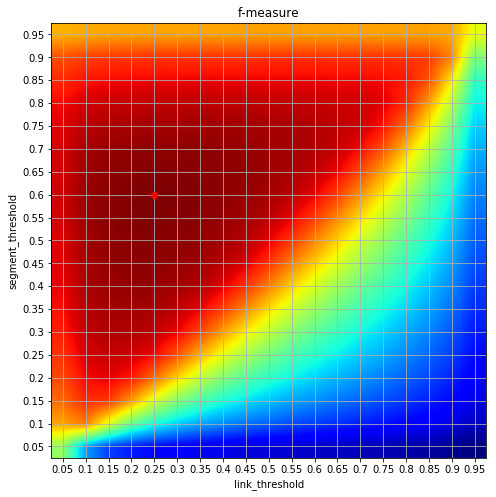

In [10]:
max_idx = np.argmax(fmes_grid)
max_idx1 = max_idx//fmes_grid.shape[0]
max_idx2 = max_idx%fmes_grid.shape[0]
print(steps_seg[max_idx1], steps_seg[max_idx2], fmes_grid[max_idx1,max_idx2])
plt.figure(figsize=[8]*2)
plt.imshow(fmes_grid, cmap='jet', origin='lower', interpolation='bilinear') # nearest, bilinear, bicubic
plt.title('f-measure')
plt.xticks(range(len(steps_lnk)), steps_lnk.astype('float32'))
plt.yticks(range(len(steps_seg)), steps_seg.astype('float32'))
plt.plot(max_idx2, max_idx1, 'or')
plt.xlabel('link_threshold')
plt.ylabel('segment_threshold')
plt.grid()
#plt.savefig('plots/%s_gridsearch.pgf' % (plot_name), bbox_inches='tight')
plt.show()

### Precisions, Recall, F-measue

In [16]:
#segment_threshold = 0.6; link_threshold = 0.45
#segment_threshold = 0.55; link_threshold = 0.45
segment_threshold = 0.6; link_threshold = 0.25
batch_size = 32

max_samples = gt_util_val.num_samples
max_samples = batch_size * 32

test_gt = []
test_results = []

for i in tqdm(range(int(np.ceil(max_samples/batch_size)))):
    inputs_, data_ = gt_util_val.sample_batch(batch_size, i)
    preds_ = model.predict(inputs_, batch_size, verbose=0)
    results_ = [prior_util.decode(p, segment_threshold, link_threshold) for p in preds_]
    test_gt.extend(data_)
    test_results.extend(results_)

TP, FP, FN = evaluate_results(test_gt, test_results)
recall = TP / (TP+FN)
precision = TP / (TP+FP)
fmes = fscore(precision, recall)

print('samples train     %i' % (gt_util_train.num_samples))
print('samples val       %i' % (gt_util_val.num_samples))

print('samples           %i' % (max_samples))
print('segment_threshold %0.3f' % (segment_threshold))
print('link_threshold    %0.3f' % (link_threshold))
print('precision         %0.3f' % (precision))
print('recall            %0.3f' % (recall))
print('f-measure         %0.3f' % (fmes))

trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('trainable parameters     %10i' %(trainable_count))
print('non-trainable parameters %10i' %(non_trainable_count))
calc_memory_usage(model)

100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


samples train     772874
samples val       85875
samples           1024
segment_threshold 0.600
link_threshold    0.250
precision         0.884
recall            0.853
f-measure         0.868
trainable parameters       24358681
non-trainable parameters          0
model memory usage   421.30 MB


### Log

In [ ]:
def plot_log(log_file, names=None, limits=None, window_length=250, log_file_compare=None):
    
    def load_log(log_file):
        with open(log_file,'r') as f:
            data = f.readlines()
        keys = json.loads(data[0]).keys()
        d = {k:[] for k in keys}
        for i, line in enumerate(data):
            if not limits == None and (i < limits[0] or i > limits[1]):
                continue
            dat = json.loads(line)
            for k in keys:
                d[k].append(dat[k])
        d = {k:np.array(d[k]) for k in keys}
        return d
    
    d = load_log(log_file)
    print(log_file)
    
    if log_file_compare is not None:
        d2 = load_log(log_file_compare)
        print(log_file_compare)
    
    if names is None:
        names = [k for k in d.keys() if k not in ['epoch', 'batch', 'iteration']]
    else:
        names = [k for k in names if k in d.keys()]
    print(names)

    iteration = d['iteration']
    epoch = d['epoch']
    idx = []
    for i in range(1,len(epoch)):
        if epoch[i] != epoch[i-1]:
            idx.append(i)
    
    # reduce epoch ticks
    max_ticks = 20
    n = len(idx)
    if n > 1:
        n = round(n,-1*int(np.floor(np.log10(n))))
        while n >= max_ticks:
            if n/2 < max_ticks:
                n /= 2
            else:
                if n/5 < max_ticks:
                    n /= 5
                else:
                    n /= 10
        idx_step = int(np.ceil(len(idx)/n))
        epoch_step = epoch[idx[idx_step]] - epoch[idx[0]]
        for first_idx in range(len(idx)):
            if epoch[idx[first_idx]] % epoch_step == 0:
                break
        idx_red = [idx[i] for i in range(first_idx, len(idx), idx_step)]
    else:
        idx_red = idx
    
    if window_length is not None:
        #w = np.ones(window_length) # moving average
        w = np.hanning(window_length) # hanning window
        wh = int(window_length/2)
    
    fig, axs = plt.subplots(len(names), 1, figsize=(6,16))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.8/(len(names)-1), wspace=0)
    
    for i, k in enumerate(names):
        if k in ['epoch', 'batch', 'iteration', 'time']:
            continue
        #plt.figure(figsize=(16, 8))
        plt.axes(axs[i])
        plt.plot(iteration, d[k], zorder=0)
        
        # filter signal
        if window_length and len(iteration) > window_length:
            x = iteration[wh-1:-wh]
            y = np.convolve(w/w.sum(), d[k], mode='valid')
            plt.plot(x, y)
        
        # second log
        if log_file_compare is not None and k in d2.keys():
            plt.plot(d2['iteration'], d2[k], zorder=0)
            
            if window_length and len(d2['iteration']) > window_length:
                x = d2['iteration'][wh-1:-wh]
                y = np.convolve(w/w.sum(), d2[k], mode='valid')
                plt.plot(x, y)
        
        xmin = iteration[0]
        xmax = iteration[-1]
        plt.title(k, y=1.05)
        ax1 = plt.gca()
        ax1.set_xlim(xmin, xmax)
        ax1.yaxis.grid(True)
        #ax1.set_xlabel('iteration')
        #ax1.set_yscale('linear')
        ax1.get_yaxis().get_major_formatter().set_useOffset(False)
        
        ax2 = ax1.twiny()
        ax2.xaxis.grid(True)
        ax2.set_xticks(iteration[idx_red])
        ax2.set_xticklabels(epoch[idx_red])
        ax2.set_xlim(xmin, xmax)
        #ax2.set_xlabel('epoch')
        #ax2.set_yscale('linear')
        ax2.get_yaxis().get_major_formatter().set_useOffset(False)
        
        ymin = 0
        ymax = np.mean(d[k]) * 8
        ax1.set_ylim(ymin, ymax)
        
        #plt.savefig('plots/%s_loss_%i-%i.pgf' % (plot_name, limits[0], limits[1]), bbox_inches='tight')
        #plt.savefig('plots/%s_loss_%i-%i.png' % (plot_name, limits[0], limits[1]), bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
# SegLink
plot_log(checkdir+'/log.json', None, [0, np.inf], window_length=1000)

In [ ]:
# SegLink + DenseNet + Focal Loss
names = ['loss', 'seg_conf_loss', 'seg_loc_loss', 'link_conf_loss']
plot_log(checkdir+'/log.json', names, [0, 12000], window_length=1000)
plot_log(checkdir+'/log.json', names, [12000, 300000], window_length=1000)

### History

In [ ]:
with open(checkdir+'/history.json','r') as f:
    hist = json.load(f)
signals = [k for k in hist.keys() if not k.startswith('val_')]
print('\n'.join(signals))
epochs = np.arange(1,len(hist['loss'])+1)
plt.figure(figsize=(8,4))
plt.plot(epochs, hist['loss'])
plt.plot(epochs, hist['val_loss'])
plt.title('loss')
plt.legend(['training','validation'])
#plt.xlim([0.0, 8.0])
plt.grid()
plt.show()

In [ ]:
#signals = ['seg_precision', 'seg_recall', 'seg_fmeasure', 'link_precision', 'link_recall', 'link_fmeasure']
signals = ['seg_conf_loss', 'seg_loc_loss', 'link_conf_loss']
fig, axs = plt.subplots(1, len(signals), figsize=(16,4))
for i, s in enumerate(signals):
    axs[i].plot(epochs, hist[s])
    axs[i].plot(epochs, hist['val_'+s])
    axs[i].set_title(s)
plt.show()

### Geometry

In [ ]:
idx = 0

In [ ]:
# combined bounding boxes
plt.figure(figsize=[12]*2)
plt.imshow(images[idx])
prior_util.decode(preds[idx], segment_threshold, link_threshold, debug=False, debug_combining=True)
#gt_util.plot_gt(test_gt, show_labels=False)
#prior_util.plot_results(show_labels=False)
plt.axis('off')
plt.xlim(0, images[idx].shape[0]); 
plt.ylim(images[idx].shape[1], 0)
#plt.savefig('plots/%s_combining.pgf' % (plot_name), bbox_inches='tight')
plt.show()

In [ ]:
# detected segments and links
plt.figure(figsize=[12]*2)
plt.imshow(images[idx])
prior_util.decode(preds[idx], segment_threshold, link_threshold, debug=True, debug_combining=False)
#gt_util.plot_gt(test_gt, show_labels=False)
#prior_util.plot_results(show_labels=False)
plt.axis('off')
#plt.savefig('plots/%s_decoding.pgf' % (plot_name), bbox_inches='tight')
plt.show()

In [ ]:
# assignment of local ground truth
plt.figure(figsize=[12]*2)
plt.imshow(images[idx])
prior_util.encode(data[idx], debug=False)
prior_util.plot_gt()

for j in range(5):
    prior_util.plot_assignment(j)

plt.axis('off')
#plt.savefig('plots/%s_assignment.pgf' % (plot_name), bbox_inches='tight')
plt.show()

In [ ]:
# local predictions, TP (green), FP (blue), FN (red)
plt.figure(figsize=[12]*2)
plt.imshow(images[idx])
enc_gt = prior_util.encode(data[idx], debug=False)
prior_util.plot_local_evaluation(enc_gt, preds[idx])

plt.axis('off')
#plt.savefig('plots/%s_local_evaluation.pgf' % (plot_name), bbox_inches='tight')
plt.show()

In [ ]:
# prior boxes with links
plt.figure(figsize=[12]*2)
plt.imshow(images[idx])

i = 3 # map idx
m = prior_util.prior_maps[i]
ms = m.map_size[0]

m.plot_boxes(2 + 1*ms + 3*np.arange(1))
prior_util.plot_neighbors(i, 2 + 3*ms + 3*np.arange(1), cross_layer=False, inter_layer=True, color='r')
prior_util.plot_neighbors(i, 2 + 5*ms + 3*np.arange(1), cross_layer=True, inter_layer=False, color='b')

prior_util.prior_maps[i].plot_locations(color='r')
prior_util.prior_maps[i-1].plot_locations(color='b')

plt.axis('off')
#plt.savefig('plots/%s_segments_and_links.pgf' % (plot_name), bbox_inches='tight')
plt.show()

### Profiling

In [ ]:
%%timeit
_ = evaluate_results(data, results)

In [ ]:
%%timeit
_ = [prior_util.decode(p, segment_threshold=segment_threshold, link_threshold=link_threshold) for p in preds]

In [ ]:
# profile prior_util.decode evaluate_results
from cProfile import Profile
pr = Profile()
pr.enable()

fmes_grid = np.zeros((len(steps_seg),len(steps_lnk)))

for i, segment_threshold in enumerate(steps_seg):
    for j, link_threshold in enumerate(steps_lnk):
        results = [prior_util.decode(p, segment_threshold=segment_threshold, link_threshold=link_threshold) for p in preds]
        TP, FP, FN = evaluate_results(data, results)
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        fmes = fscore(precision, recall)
        fmes_grid[i,j] = fmes

pr.disable()
pr.print_stats(sort='cumulative')

In [ ]:
# profile prior_util.decode
from cProfile import Profile
pr = Profile()
pr.enable()

fmes_grid = np.zeros((len(steps_seg),len(steps_lnk)))

for i, segment_threshold in enumerate(steps_seg):
    for j, link_threshold in enumerate(steps_lnk):
        results = [prior_util.decode(p, segment_threshold=segment_threshold, link_threshold=link_threshold) for p in preds]
        
pr.disable()
pr.print_stats(sort='cumulative')
